# We show how can use caption images using the powerful DINOv3 embedder and Transformer Decoder. It can be divided into 2 steps :
## **Step 1** : Create features for Images Using DINOv3
## **Step 2** : Train Transformer Decoder Model which predicts next word given a sequence of tokens and Image Features from Step1
## This notebook is a modification of [Dipanjan Das' work](https://www.kaggle.com/code/dipanjandas96/image-caption-resnet-transformerdecoder-pytorch/notebook)

In [2]:
import pandas as pd
import numpy as np
from collections import Counter 
import torchvision
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
import pickle
import gc
import random
pd.set_option('display.max_colwidth', None)

## Read Data.

In [3]:
df = pd.read_csv("flickr/captions.txt", sep=',')
print(len(df))
display(df.head(3))

40455


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .


## Preprocessing -> Remove Single Character and non alpha Words. Add <Start>, <end> and <pad> tokens. <pad> token is appended such that length in max_seq_len (maximum length across all captions which is 33 in our case)  

In [4]:
def remove_single_char_word(word_list):
    lst = []
    for word in word_list:
        if len(word)>1:
            lst.append(word)

    return lst

In [5]:
df['cleaned_caption'] = df['caption'].apply(lambda caption : ['<start>'] + [word.lower() if word.isalpha() else '' for word in caption.split(" ")] + ['<end>'])
df['cleaned_caption']  = df['cleaned_caption'].apply(lambda x : remove_single_char_word(x))

In [6]:
df['seq_len'] = df['cleaned_caption'].apply(lambda x : len(x))
max_seq_len = df['seq_len'].max()
print(max_seq_len)

33


In [7]:
df.drop(['seq_len'], axis = 1, inplace = True)
df['cleaned_caption'] = df['cleaned_caption'].apply(lambda caption : caption + ['<pad>']*(max_seq_len-len(caption)) )

In [8]:
display(df.head(2))

,image,caption,cleaned_caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .,"[<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[<start>, girl, going, into, wooden, building, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"


## Create Vocab and mapping of token to ID

In [9]:
word_list = df['cleaned_caption'].apply(lambda x : " ".join(x)).str.cat(sep = ' ').split(' ')
word_dict = Counter(word_list)
word_dict =  sorted(word_dict, key=word_dict.get, reverse=True)

In [10]:
print(len(word_dict))
print(word_dict[:5])

8360
['<pad>', '<start>', '<end>', 'in', 'the']


### Vocab size is 8360

In [11]:
vocab_size = len(word_dict)
print(vocab_size)

8360


In [12]:
index_to_word = {index: word for index, word in enumerate(word_dict)}
word_to_index = {word: index for index, word in enumerate(word_dict)}
print(len(index_to_word), len(word_to_index))

8360 8360


### Covert sequence of tokens to IDs

In [13]:
df['text_seq']  = df['cleaned_caption'].apply(lambda caption : [word_to_index[word] for word in caption] )

In [14]:
display(df.head(2))

,image,caption,cleaned_caption,text_seq
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .,"[<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 41, 3, 89, 168, 6, 118, 52, 392, 11, 389, 3, 27, 5075, 690, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[<start>, girl, going, into, wooden, building, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 18, 311, 63, 192, 116, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


## Split In Train and validation data. Same Image should not be present in both training and validation data 

In [15]:
df = df.sort_values(by = 'image')
train = df.iloc[:int(0.9*len(df))]
valid = df.iloc[int(0.9*len(df)):]

In [16]:
print(len(train), train['image'].nunique())
print(len(valid), valid['image'].nunique())

36409 7282
4046 810


## Extract features from Images Using DINOV3

In [17]:
train_samples = len(train)
print(train_samples)

36409


In [18]:
unq_train_imgs = train[['image']].drop_duplicates()
unq_valid_imgs = valid[['image']].drop_duplicates()
print(len(unq_train_imgs), len(unq_valid_imgs))

7282 810


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [19]:
class extractImageFeatureDinoDataSet():
    def __init__(self, data):
        self.data = data 
        self.scaler = transforms.Resize([224, 224])
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()
    def __len__(self):  
        return len(self.data)

    def __getitem__(self, idx):

        image_name = self.data.iloc[idx]['image']
        img_loc = 'flickr/Images/'+str(image_name)

        img = Image.open(img_loc)
        t_img = self.normalize(self.to_tensor(self.scaler(img)))

        return image_name, t_img

In [20]:
train_ImageDataset_DINO = extractImageFeatureDinoDataSet(unq_train_imgs)
train_ImageDataloader_DINO = DataLoader(train_ImageDataset_DINO, batch_size = 1, shuffle=False)

In [21]:
valid_ImageDataset_DINO = extractImageFeatureDinoDataSet(unq_valid_imgs)
valid_ImageDataloader_DINO = DataLoader(valid_ImageDataset_DINO, batch_size = 1, shuffle=False)

## You must download the weights off the [official repository](https://github.com/facebookresearch/dinov3?tab=readme-ov-file).
## This tutorial uses the ViT-L/16 distilled model.	

In [22]:
dino = torch.hub.load(repo_or_dir="facebookresearch/dinov3",
    model="dinov3_vitl16", pretrained=False)
dino.load_state_dict(torch.load('dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth'))
dino.to(device)
dino.eval()

Using cache found in /home/tasin/.cache/torch/hub/facebookresearch_dinov3_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (rope_embed): RopePositionEmbedding()
  (blocks): ModuleList(
    (0-23): 24 x SelfAttentionBlock(
      (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (attn): SelfAttention(
        (qkv): LinearKMaskedBias(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
    )
  )
  (norm)

In [23]:
def get_vector(t_img):
    feats = dino.get_intermediate_layers(t_img, n=range(24), reshape=True, norm=True)
    return feats

In [28]:
extract_imgFtr_ResNet_train = {}
with torch.no_grad():
    for image_name, t_img in tqdm(train_ImageDataloader_DINO):
        t_img = t_img.to(device)
        embdg = get_vector(t_img)[-1]
        embdg = embdg.detach().cpu()
        extract_imgFtr_ResNet_train[image_name[0]] = embdg
        torch.cuda.empty_cache()

  0%|          | 0/7282 [00:00<?, ?it/s]

In [29]:
print(t_img.shape) 
print(embdg.shape)
temp = embdg.permute(0,2,3,1)
print( (temp.view(temp.size(0), -1, temp.size(3))).shape )

torch.Size([1, 3, 224, 224])
torch.Size([1, 1024, 14, 14])
torch.Size([1, 196, 1024])


In [30]:
a_file = open("./EncodedImageTrainDINO.pkl", "wb")
pickle.dump(extract_imgFtr_ResNet_train, a_file)
a_file.close()

In [33]:
extract_imgFtr_ResNet_valid = {}
with torch.no_grad():
    for image_name, t_img in tqdm(valid_ImageDataloader_DINO):
        t_img = t_img.to(device)
        embdg = get_vector(t_img)[-1]
        embdg = embdg.detach().cpu()
        extract_imgFtr_ResNet_valid[image_name[0]] = embdg
        torch.cuda.empty_cache()

  0%|          | 0/810 [00:00<?, ?it/s]

In [34]:
a_file = open("./EncodedImageValidDINO.pkl", "wb")
pickle.dump(extract_imgFtr_ResNet_valid, a_file)
a_file.close()

## Create DataLoader which will be used to load data into Transformer Model.
## FlickerDataSetResnet will return caption sequence, 1 timestep left shifted caption sequence which model will predict and Stored Image features from ResNet.

In [19]:
class FlickerDataSetResnet():
    def __init__(self, data, pkl_file):
        self.data = data
        self.encodedImgs = pd.read_pickle(pkl_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
    
        caption_seq = self.data.iloc[idx]['text_seq']
        target_seq = caption_seq[1:]+[0]

        image_name = self.data.iloc[idx]['image']
        image_tensor = self.encodedImgs[image_name]
        image_tensor = image_tensor.permute(0,2,3,1)
        image_tensor_view = image_tensor.view(image_tensor.size(0), -1, image_tensor.size(3))

        return torch.tensor(caption_seq), torch.tensor(target_seq), image_tensor_view

In [20]:
train_dataset_resnet = FlickerDataSetResnet(train, 'EncodedImageTrainDINO.pkl')
train_dataloader_resnet = DataLoader(train_dataset_resnet, batch_size = 32, shuffle=True)

In [22]:
valid_dataset_resnet = FlickerDataSetResnet(valid, 'EncodedImageValidDINO.pkl')
valid_dataloader_resnet = DataLoader(valid_dataset_resnet, batch_size = 32, shuffle=True)

## Create Transformer Decoder Model. This Model will take caption sequence and the extracted resnet image features as input and ouput 1 timestep shifted (left) caption sequence. 
## In the Transformer decoder, lookAhead and padding mask has also been applied

### Position Embedding

In [23]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=max_seq_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        

    def forward(self, x):
        if self.pe.size(0) < x.size(0):
            self.pe = self.pe.repeat(x.size(0), 1, 1).to(device)
        self.pe = self.pe[:x.size(0), : , : ]
        
        x = x + self.pe
        return self.dropout(x)

## Transformer Decoder

In [24]:
class ImageCaptionModel(nn.Module):
    def __init__(self, n_head, n_decoder_layer, vocab_size, embedding_size):
        super(ImageCaptionModel, self).__init__()
        self.pos_encoder = PositionalEncoding(embedding_size, 0.1)
        self.TransformerDecoderLayer = nn.TransformerDecoderLayer(d_model =  embedding_size, nhead = n_head)
        self.TransformerDecoder = nn.TransformerDecoder(decoder_layer = self.TransformerDecoderLayer, num_layers = n_decoder_layer)
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(vocab_size , embedding_size)
        self.last_linear_layer = nn.Linear(embedding_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.last_linear_layer.bias.data.zero_()
        self.last_linear_layer.weight.data.uniform_(-initrange, initrange)

    def generate_Mask(self, size, decoder_inp):
        decoder_input_mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        decoder_input_mask = decoder_input_mask.float().masked_fill(decoder_input_mask == 0, float('-inf')).masked_fill(decoder_input_mask == 1, float(0.0))

        decoder_input_pad_mask = decoder_inp.float().masked_fill(decoder_inp == 0, float(0.0)).masked_fill(decoder_inp > 0, float(1.0))
        decoder_input_pad_mask_bool = decoder_inp == 0

        return decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool

    def forward(self, encoded_image, decoder_inp):
        encoded_image = encoded_image.permute(1,0,2)
        

        decoder_inp_embed = self.embedding(decoder_inp)* math.sqrt(self.embedding_size)
        
        decoder_inp_embed = self.pos_encoder(decoder_inp_embed)
        decoder_inp_embed = decoder_inp_embed.permute(1,0,2)
        

        decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool = self.generate_Mask(decoder_inp.size(1), decoder_inp)
        decoder_input_mask = decoder_input_mask.to(device)
        decoder_input_pad_mask = decoder_input_pad_mask.to(device)
        decoder_input_pad_mask_bool = decoder_input_pad_mask_bool.to(device)
  
        decoder_output = self.TransformerDecoder(tgt = decoder_inp_embed, memory = encoded_image, tgt_mask = decoder_input_mask, tgt_key_padding_mask = decoder_input_pad_mask_bool)
        
        final_output = self.last_linear_layer(decoder_output)

        return final_output,  decoder_input_pad_mask


##  Train the Model

### The cross entropy loss has been masked at time steps where input token is <'pad'>.

In [25]:
EPOCH = 30

In [31]:
ictModel = ImageCaptionModel(16, 4, vocab_size, 1024).to(device)
optimizer = torch.optim.Adam(ictModel.parameters(), lr = 0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience=2)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
min_val_loss = float('Inf')

In [29]:
from tensorboardX import SummaryWriter
writer = SummaryWriter('new_runs')

In [32]:
for epoch in tqdm(range(EPOCH)):
    total_epoch_train_loss = 0
    total_epoch_valid_loss = 0
    total_train_words = 0
    total_valid_words = 0
    ictModel.train()

    ### Train Loop
    for caption_seq, target_seq, image_embed in train_dataloader_resnet:

        optimizer.zero_grad()

        image_embed = image_embed.squeeze(1).to(device)
        caption_seq = caption_seq.to(device)
        target_seq = target_seq.to(device)

        output, padding_mask = ictModel.forward(image_embed, caption_seq)
        output = output.permute(1, 2, 0)

        loss = criterion(output,target_seq)

        loss_masked = torch.mul(loss, padding_mask)

        final_batch_loss = torch.sum(loss_masked)/torch.sum(padding_mask)

        final_batch_loss.backward()
        optimizer.step()
        total_epoch_train_loss += torch.sum(loss_masked).detach().item()
        total_train_words += torch.sum(padding_mask)

    total_epoch_train_loss = total_epoch_train_loss/total_train_words
  

    ### Eval Loop
    ictModel.eval()
    with torch.no_grad():
        for caption_seq, target_seq, image_embed in valid_dataloader_resnet:

            image_embed = image_embed.squeeze(1).to(device)
            caption_seq = caption_seq.to(device)
            target_seq = target_seq.to(device)

            output, padding_mask = ictModel.forward(image_embed, caption_seq)
            output = output.permute(1, 2, 0)

            loss = criterion(output,target_seq)

            loss_masked = torch.mul(loss, padding_mask)

            total_epoch_valid_loss += torch.sum(loss_masked).detach().item()
            total_valid_words += torch.sum(padding_mask)

    total_epoch_valid_loss = total_epoch_valid_loss/total_valid_words
  
    print("Epoch -> ", epoch," Training Loss -> ", total_epoch_train_loss.item(), "Eval Loss -> ", total_epoch_valid_loss.item() )
    writer.add_scalar("train", total_epoch_train_loss.item(), epoch)
    writer.add_scalar("val", total_epoch_valid_loss.item(), epoch)

    if min_val_loss > total_epoch_valid_loss:
        print("Writing Model at epoch ", epoch)
        torch.save(ictModel, './BestModel')
        min_val_loss = total_epoch_valid_loss
  

    scheduler.step(total_epoch_valid_loss.item())


  0%|          | 0/30 [00:00<?, ?it/s]

/home/tasin/anaconda3/envs/DiT/lib/python3.12/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch ->  0  Training Loss ->  4.7820611000061035 Eval Loss ->  3.963045597076416
Writing Model at epoch  0
Epoch ->  1  Training Loss ->  3.792433261871338 Eval Loss ->  3.5721609592437744
Writing Model at epoch  1
Epoch ->  2  Training Loss ->  3.456117868423462 Eval Loss ->  3.38706374168396
Writing Model at epoch  2
Epoch ->  3  Training Loss ->  3.2411887645721436 Eval Loss ->  3.243373394012451
Writing Model at epoch  3
Epoch ->  4  Training Loss ->  3.0798184871673584 Eval Loss ->  3.1507489681243896
Writing Model at epoch  4
Epoch ->  5  Training Loss ->  2.9469945430755615 Eval Loss ->  3.082808256149292
Writing Model at epoch  5
Epoch ->  6  Training Loss ->  2.8345906734466553 Eval Loss ->  3.0323293209075928
Writing Model at epoch  6
Epoch ->  7  Training Loss ->  2.7374792098999023 Eval Loss ->  2.986130952835083
Writing Model at epoch  7
Epoch ->  8  Training Loss ->  2.6487865447998047 Eval Loss ->  2.957359790802002
Writing Model at epoch  8
Epoch ->  9  Training Loss -

## Lets Generate Captions !!!

In [33]:
model = torch.load('./dino_emb_transformer_dec', weights_only=False)
start_token = word_to_index['<start>']
end_token = word_to_index['<end>']
pad_token = word_to_index['<pad>']
max_seq_len = 33
print(start_token, end_token, pad_token)

1 2 0


In [40]:
valid_img_embed = pd.read_pickle('EncodedImageValidDINO.pkl')

### Here in the below function,we are generating caption in beam search. K defines the topK token to look at each time step

In [38]:
def generate_caption(K, img_nm): 
    img_loc = 'flickr/Images/'+str(img_nm)
    image = Image.open(img_loc).convert("RGB")
    plt.imshow(image)

    model.eval() 
    valid_img_df = valid[valid['image']==img_nm]
    print("Actual Caption : ")
    print(valid_img_df['caption'].tolist())
    img_embed = valid_img_embed[img_nm].to(device)


    img_embed = img_embed.permute(0,2,3,1)
    img_embed = img_embed.view(img_embed.size(0), -1, img_embed.size(3))


    input_seq = [pad_token]*max_seq_len
    input_seq[0] = start_token

    input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)
    predicted_sentence = []
    with torch.no_grad():
        for eval_iter in range(0, max_seq_len):

            output, padding_mask = model.forward(img_embed, input_seq)

            output = output[eval_iter, 0, :]

            values = torch.topk(output, K).values.tolist()
            indices = torch.topk(output, K).indices.tolist()

            next_word_index = random.choices(indices, values, k = 1)[0]

            next_word = index_to_word[next_word_index]

            input_seq[:, eval_iter+1] = next_word_index


            if next_word == '<end>' :
                break

            predicted_sentence.append(next_word)
    print("\n")
    print("Predicted caption : ")
    print(" ".join(predicted_sentence+['.']))

### 1st Example 

Actual Caption : 
['Young child in pink top and purple pants clutching a turquoise guard rail .', 'A very young girl is walking on a playground .', 'The little girl is playing at the playground .', 'A little girl in pink and purple stands on a playground .', 'A female toddler wearing a pink shirt is playing on a playground .']


Predicted caption : 
little girl in pink top is standing on playground equipment .


/home/tasin/anaconda3/envs/DiT/lib/python3.12/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


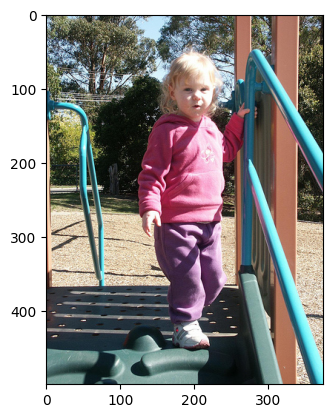

In [41]:
generate_caption(1, unq_valid_imgs.iloc[50]['image'])

In [ ]:
generate_caption(2, unq_valid_imgs.iloc[50]['image'])

### 2nd Example

Actual Caption : 
['A distant person is climbing up a very sheer mountain .', 'A panoramic distance view of a rock climber going up a steep mountain wall .', 'person rock climbing', 'There is a person scaling a very steep rock wall .', 'This person is climbing the side of a mountain .']


Predicted caption : 
man climbs up steep rock face .


/home/tasin/anaconda3/envs/DiT/lib/python3.12/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


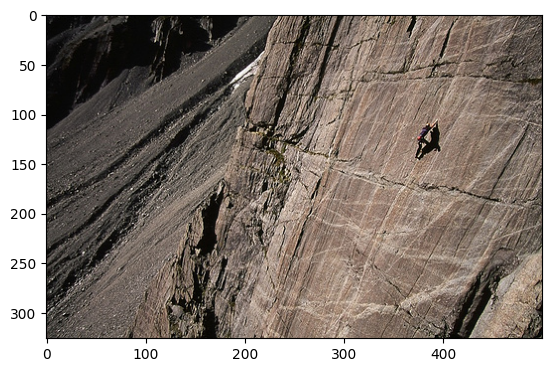

In [43]:
generate_caption(1, unq_valid_imgs.iloc[100]['image'])

In [ ]:
generate_caption(2, unq_valid_imgs.iloc[100]['image'])

### 3rd Example

Actual Caption : 
['A curly haired dog tries to bite another dog wearing a green and orange collar .', 'One brown dog is bearing its teeth at another brown dog with a green collar in a park .', 'Two brown dogs playing .', 'Two dogs , one with its mouth open .', 'Two golden dogs playing with one another']


Predicted caption : 
two dogs one brown one white and one brown dog are playing in the park .


/home/tasin/anaconda3/envs/DiT/lib/python3.12/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


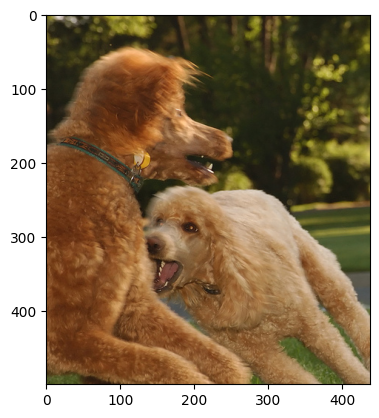

In [45]:
generate_caption(1, unq_valid_imgs.iloc[500]['image'])

Actual Caption : 
['A curly haired dog tries to bite another dog wearing a green and orange collar .', 'One brown dog is bearing its teeth at another brown dog with a green collar in a park .', 'Two brown dogs playing .', 'Two dogs , one with its mouth open .', 'Two golden dogs playing with one another']


Predicted caption : 
brown and white dogs are playing together .


/home/tasin/anaconda3/envs/DiT/lib/python3.12/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


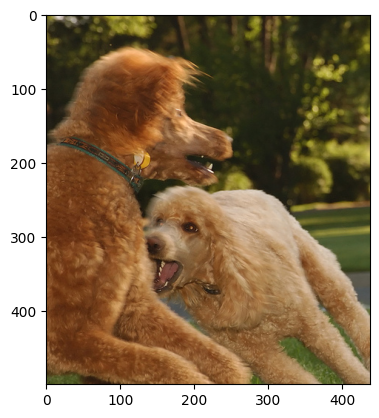

In [50]:
generate_caption(2, unq_valid_imgs.iloc[500]['image'])

### 4rth Example

Actual Caption : 
['The dog has his tongue sticking out and walking in the grass .', 'Brown and white dog runs at camera over grass .', 'A spaniel runs through the grass .', 'A brown dog with very floppy ears runs through a field of emerald grass .', 'A fluffy dog in grass .']


Predicted caption : 
brown dog is running through the grass .


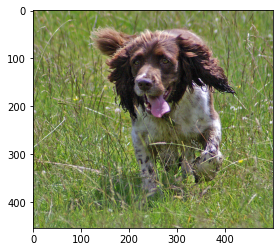

In [46]:
generate_caption(1, unq_valid_imgs.iloc[600]['image'])

In [ ]:
generate_caption(2, unq_valid_imgs.iloc[600]['image'])